In [252]:
import os
import numpy as np
import pandas as pd
from arcgis import GIS
from arcgis.features import GeoAccessor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap
from matplotlib import pyplot as plt

# show all columns
pd.options.display.max_columns = None

plt.rcParams.update({'figure.figsize': (14.0, 10.0)})
plt.rcParams.update({'font.size': 14})

In [253]:
outputs = r'.\Outputs'
if not os.path.exists(outputs):
    os.makedirs(outputs)

# 1) Data Prep

In [254]:
# read in inputs
b_vars = pd.read_csv(r".\Inputs\run423year2019allbuildings.csv") # building
n_vars = pd.read_csv(r".\Inputs\run423year2019nodevariables.csv") # node
z_vars = pd.read_csv(r".\Inputs\run423year2019zonalvariables.csv") # zone
c_vars = pd.read_csv(r".\Inputs\buildings_for_estimation_grouped_REMM2.csv") # commercial

# rename identical columns
b_vars.rename({'population':'population_b'}, axis=1, inplace=True)
z_vars.rename({'population':'population_z'}, axis=1, inplace=True)

# rename duplicate columns in commercial data
c_vars.rename({'improvement_value':'improvement_value_c', 'non_residential_sqft':'non_residential_sqft_c', 'building_type_id':'building_type_id_c', 'year_built':'year_built_c', 'residential_units':'residential_units_c', 
             'unit_price_residential':'unit_price_residential_c', 'unit_price_non_residential':'unit_price_non_residential_c', 'stories':'stories_c', 'building_sqft':'building_sqft_c'}, axis=1, inplace=True)

# delete unneeded commercial columns
del c_vars['building_id']
del c_vars['X']
del c_vars['Y']

# remove store ids from c_vars
c_vars = c_vars[c_vars['parcel_id'] > 0].copy()
building_ids_c = c_vars['parcel_id'].to_list()


# join utm coords 
parcels = r"E:\REMM\Base_Year_Data_2019\v1\remm_base_year_20220513.gdb\parcels_2019"
parcels = pd.DataFrame.spatial.from_featureclass(parcels)[['parcel_id_REMM', 'x', 'y']].copy()
parcels.columns = ['parcel_id', 'utmxi','utmyi']
b_vars = b_vars.merge(parcels, on='parcel_id', how='left')
del parcels

In [255]:
# check for duplicates
b_vars_names = list(b_vars.columns)
n_vars_names = list(n_vars.columns)
z_vars_names = list(z_vars.columns)
c_vars_names = list(c_vars.columns)

all_names = b_vars_names + n_vars_names + z_vars_names + c_vars_names
seen = set()
dupes = [name for name in all_names if name in seen or seen.add(name)]
print(dupes)   

['node_id', 'zone_id', 'parcel_id']


In [256]:
# combine variables
tbl = b_vars.merge(z_vars, on='zone_id', how='left')
tbl = tbl.merge(n_vars, on='node_id', how='left')

tbl['log1p_fwy_exit_dist_tdm_output'] = np.log1p(tbl['fwy_exit_dist_tdm_output'])
tbl['log1p_rail_stn_dist'] =  np.log1p(tbl['rail_stn_dist'])
tbl['log1p_sqft_per_unit'] =  np.log1p(tbl['sqft_per_unit'])
tbl['log1p_university_dist'] = np.log1p(tbl['university_dist'])
tbl['log1p_real_far'] = np.log1p(tbl['real_far'])
tbl['log1p_building_age'] = np.log1p(tbl['building_age'])

tbl.loc[(tbl['avg_building_age'] < 21), 'avg_building_age_lt_21'] = 1
tbl.loc[~(tbl['avg_building_age'] < 21), 'avg_building_age_lt_21'] = 0

tbl.loc[(tbl['year_built'] < 21), 'year_built_lt_1945'] = 1
tbl.loc[~(tbl['year_built'] < 21), 'year_built_lt_1945'] = 0

In [257]:
# create tables for each county
tbl_57 = tbl[tbl['county_id']==57].copy()
tbl_11 = tbl[tbl['county_id']==11].copy()
tbl_35 = tbl[tbl['county_id']==35].copy()
tbl_49 = tbl[tbl['county_id']==49].copy()

# join the commercial table. NOTE: This will create additional records
tbl = tbl.merge(c_vars, on='parcel_id', how='left')

# create separate commercial table for each county
comm_57 = tbl[(tbl['county_id']==57) & (tbl['parcel_id'].isin(building_ids_c) == True)].copy()
comm_11 = tbl[(tbl['county_id']==11) & (tbl['parcel_id'].isin(building_ids_c) == True)].copy()
comm_35 = tbl[(tbl['county_id']==35) & (tbl['parcel_id'].isin(building_ids_c) == True)].copy()
comm_49 = tbl[(tbl['county_id']==49) & (tbl['parcel_id'].isin(building_ids_c) == True)].copy()

# tbl_57.to_csv(os.path.join(outputs, 'buildings_nodes_zones_57.csv'), index=False)
# tbl_11.to_csv(os.path.join(outputs, 'buildings_nodes_zones_11.csv'), index=False)
# tbl_35.to_csv(os.path.join(outputs, 'buildings_nodes_zones_35.csv'), index=False)
# tbl_49.to_csv(os.path.join(outputs, 'buildings_nodes_zones_49.csv'),index=False)

In [258]:
vars_to_exclude = ['parcel_id', 'building_id', 'note', 'zone_1212']

In [259]:
# drop columns
tbl_57.drop(vars_to_exclude, axis=1, inplace=True)
tbl_11.drop(vars_to_exclude, axis=1, inplace=True)
tbl_35.drop(vars_to_exclude, axis=1, inplace=True)
tbl_49.drop(vars_to_exclude, axis=1, inplace=True)

# 2) Analysis

# Single Family (Residential Unit Price)

###  Weber

In [260]:
# arguments - check these
data = tbl_57
y_var = 'res_price_per_sqft'

old_vars =  ['ave_income_500',
             'commute_time',
             'distmed_1',
             'distmed_2',
             'distmed_3',
             'distmed_4',
             'distmed_5',
             'distmed_6',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'log1p_rail_stn_dist', # np.log1p(rail_stn_dist)
             'log1p_sqft_per_unit', # np.log1p(sqft_per_unit)
             'log1p_university_dist', # np.log1p(university_dist)
             'parcel_volume',
             'avg_building_age_lt_21',  #I(avg_building_age < 21)[T.True],
             'year_built_lt_1945', #I(year_built < 1945)[T.True]
            ]

In [261]:
# filters
sf = data[(data['building_type_id'] == 1) & (data['res_price_per_sqft'] > 0)]

# get desired columns
sf = sf[old_vars + [y_var]]

# separate independent and dependent variables
x_vars = sf[old_vars].copy()
y_var = sf[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:45076


In [262]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 0.875
Mean Squared Error: 1.865
R-squared scores: 0.986


Text(0.5, 0, 'Random Forest Feature Importance')

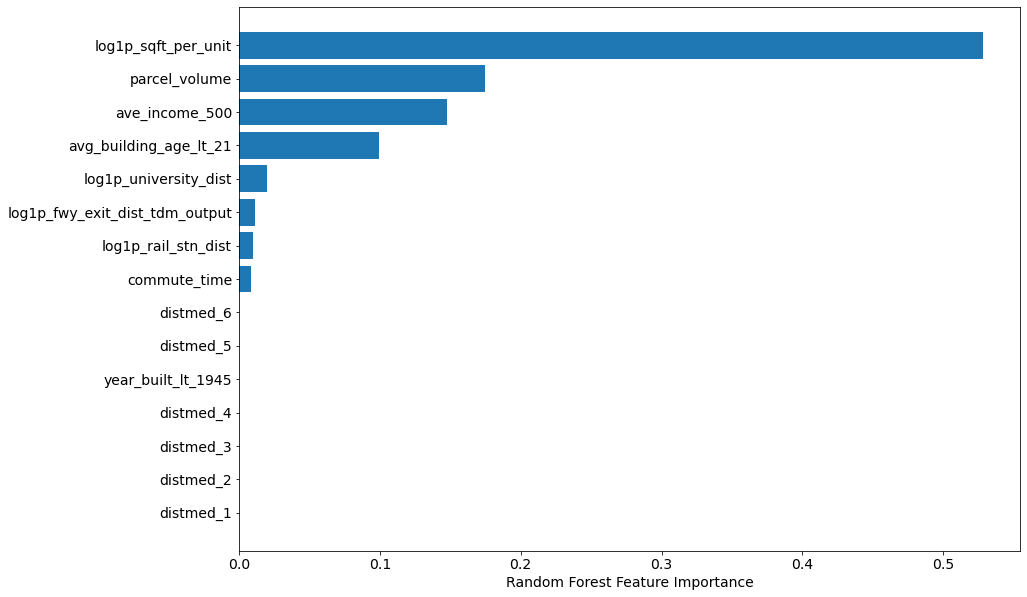

In [263]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Davis

In [264]:
# arguments - check these
data = tbl_11
y_var = 'res_price_per_sqft'

old_vars =  ['ave_income_500',
             'commute_time',
             'distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_7',
             'distmed_8',
             'distmed_9',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'log1p_rail_stn_dist', # np.log1p(rail_stn_dist)
             'log1p_sqft_per_unit', # np.log1p(sqft_per_unit)
             'log1p_university_dist', # np.log1p(university_dist)
             'parcel_volume',
             'avg_building_age_lt_21',  #I(avg_building_age < 21)[T.True],
             'year_built_lt_1945', #I(year_built < 1945)[T.True]
            ]

In [265]:
# filters
sf = data[(data['building_type_id'] == 1) & (data['res_price_per_sqft'] > 0)]

# get desired columns
sf = sf[old_vars + [y_var]]

# separate independent and dependent variables
x_vars = sf[old_vars].copy()
y_var = sf[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:61584


In [266]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 0.904
Mean Squared Error: 6.422
R-squared scores: 0.984


Text(0.5, 0, 'Random Forest Feature Importance')

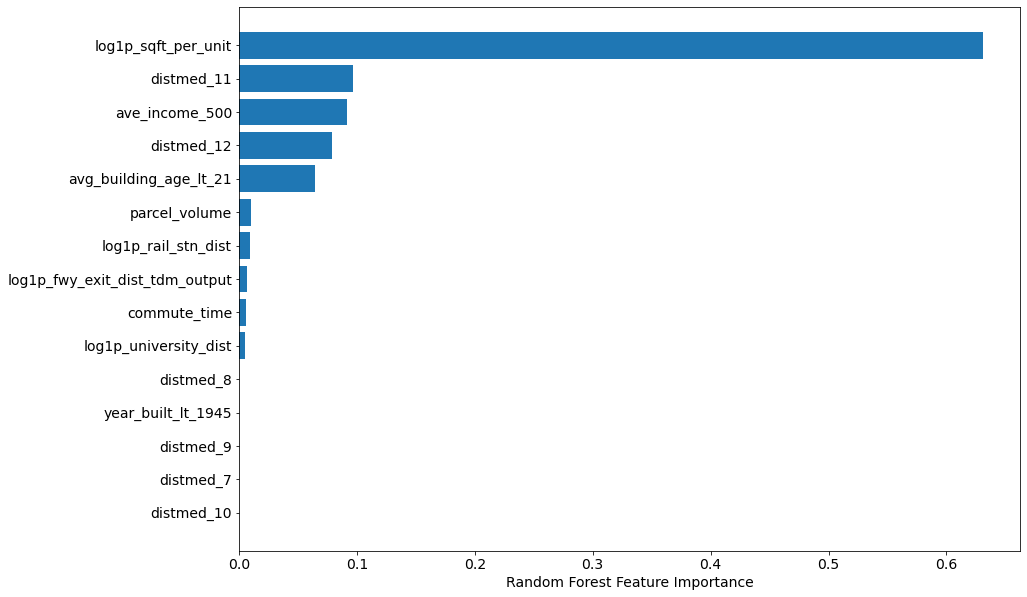

In [267]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Salt Lake

In [268]:
# arguments - check these
data = tbl_35
y_var = 'res_price_per_sqft'

old_vars =  ['ave_income_500',
             'commute_time',
             'distmed_13',
             'distmed_14',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_20',
             'distmed_21',
             'distmed_22',
             'distmed_23',
             'distmed_24',
             'distmed_25',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_30',
             'distmed_31',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'log1p_rail_stn_dist', # np.log1p(rail_stn_dist)
             'log1p_sqft_per_unit', # np.log1p(sqft_per_unit)
             'log1p_university_dist', # np.log1p(university_dist)
             'parcel_volume',
             'avg_building_age_lt_21',  #I(avg_building_age < 21)[T.True],
             'year_built_lt_1945', #I(year_built < 1945)[T.True]
            ]

In [269]:
# filters
sf = data[(data['building_type_id'] == 1) & (data['res_price_per_sqft'] > 0)]

# get desired columns
sf = sf[old_vars + [y_var]]

# separate independent and dependent variables
x_vars = sf[old_vars].copy()
y_var = sf[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:176217


In [270]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 0.43
Mean Squared Error: 2.793
R-squared scores: 0.988


Text(0.5, 0, 'Random Forest Feature Importance')

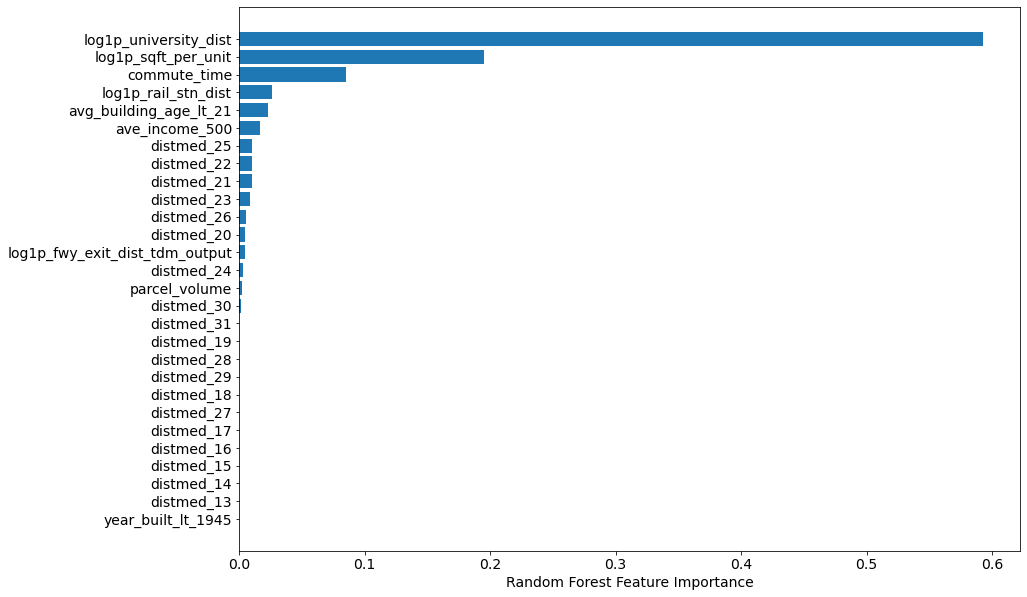

In [271]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Utah

In [272]:
# arguments - check these
data = tbl_49
y_var = 'res_price_per_sqft'

old_vars =  ['ave_income_500',
             'commute_time',
             'distmed_32',
             'distmed_33',
             'distmed_34',
             'distmed_35',
             'distmed_36',
             'distmed_37',
             'distmed_38',
             'distmed_39',
             'distmed_40',
             'distmed_41',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'log1p_rail_stn_dist', # np.log1p(rail_stn_dist)
             'log1p_sqft_per_unit', # np.log1p(sqft_per_unit)
             'log1p_university_dist', # np.log1p(university_dist)
             'parcel_volume',
             'avg_building_age_lt_21',  #I(avg_building_age < 21)[T.True],
             'year_built_lt_1945', #I(year_built < 1945)[T.True]
            ]

In [273]:
# filters
sf = data[(data['building_type_id'] == 1) & (data['res_price_per_sqft'] > 0)]

# get desired columns
sf = sf[old_vars + [y_var]]

# separate independent and dependent variables
x_vars = sf[old_vars].copy()
y_var = sf[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:92187


In [274]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 0.388
Mean Squared Error: 4.252
R-squared scores: 0.946


Text(0.5, 0, 'Random Forest Feature Importance')

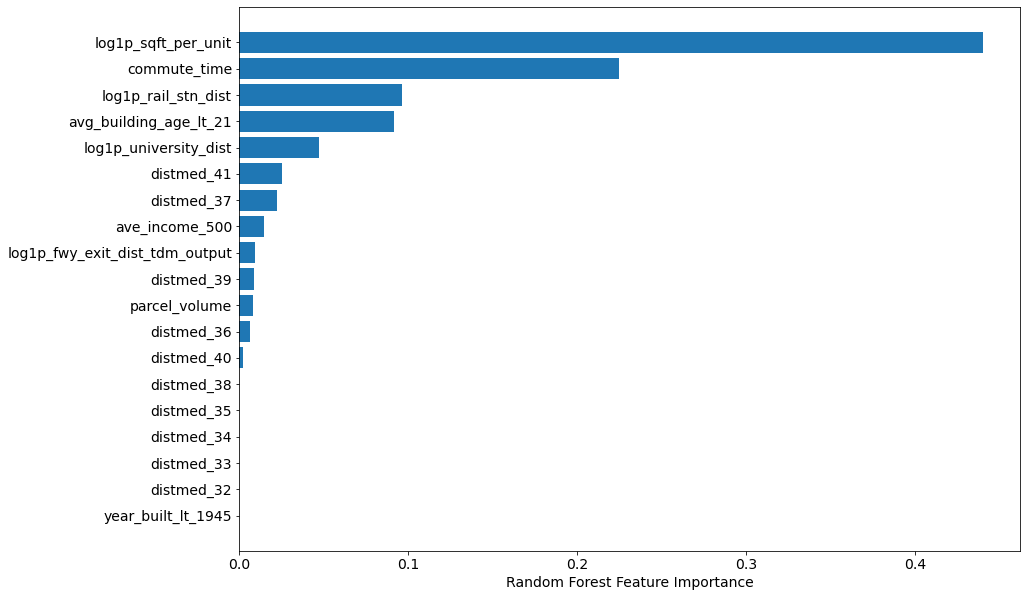

In [275]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

# Multifamily (Residential Unit Price)

###  Weber

In [276]:
# arguments - check these
data = tbl_57
y_var = 'res_price_per_sqft'

old_vars =  ['ave_income_500',
             'commute_time',
             'distmed_1',
             'distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_13',
             'distmed_14',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_2',
             'distmed_20',
             'distmed_21',
             'distmed_22',
             'distmed_23',
             'distmed_24',
             'distmed_25',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_3',
             'distmed_30',
             'distmed_31',
             'distmed_36',
             'distmed_4',
             'distmed_5',
             'distmed_6',
             'distmed_7',
             'distmed_8',
             'distmed_9',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'mfdu_500',
             'log1p_sqft_per_unit', # np.log1p(sqft_per_unit)
             'log1p_real_far', # np.log1p(university_dist)
             'parcel_volume',
             'avg_building_age',  #I(avg_building_age < 21)[T.True]
            ]

In [277]:
# filters
mf = data[(data['building_type_id'] == 2) & (data['res_price_per_sqft'] > 0)].copy()

# get desired columns
mf = mf[old_vars + [y_var]].copy()

# separate independent and dependent variables
x_vars = mf[old_vars].copy()
y_var = mf[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:2002


In [278]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 2.326
Mean Squared Error: 39.865
R-squared scores: 0.868


Text(0.5, 0, 'Random Forest Feature Importance')

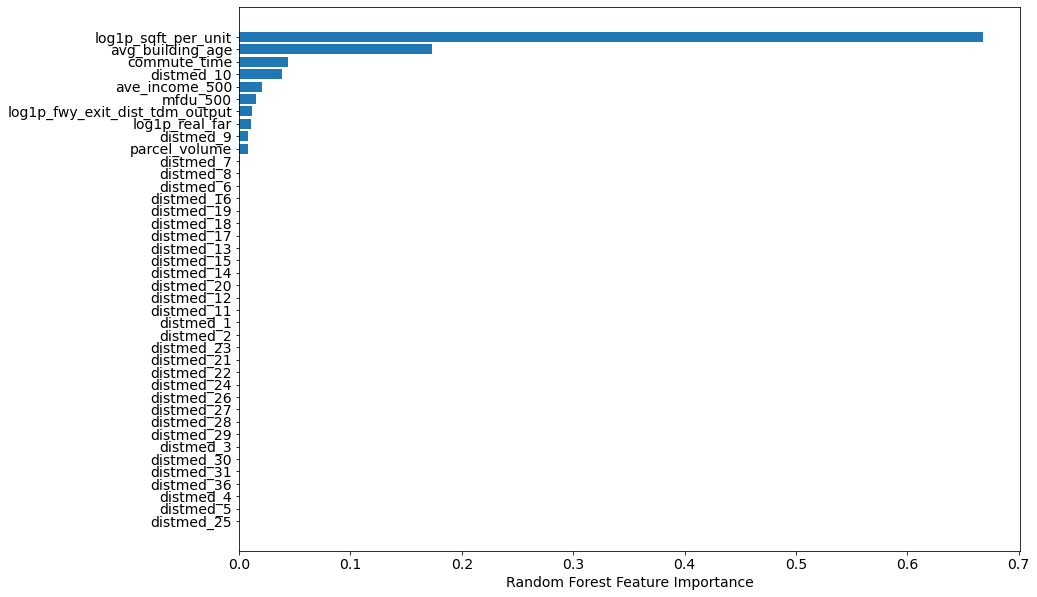

In [279]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Davis

In [280]:
# arguments - check these
data = tbl_11
y_var = 'res_price_per_sqft'

old_vars =  ['ave_income_500',
             'commute_time',
             'distmed_1',
             'distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_13',
             'distmed_14',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_2',
             'distmed_20',
             'distmed_21',
             'distmed_22',
             'distmed_23',
             'distmed_24',
             'distmed_25',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_3',
             'distmed_30',
             'distmed_31',
             'distmed_36',
             'distmed_4',
             'distmed_5',
             'distmed_6',
             'distmed_7',
             'distmed_8',
             'distmed_9',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'mfdu_500',
             'log1p_sqft_per_unit', # np.log1p(sqft_per_unit)
             'log1p_real_far', # np.log1p(university_dist)
             'parcel_volume',
             'avg_building_age',  #I(avg_building_age < 21)[T.True]
            ]

In [281]:
# filters
mf = data[(data['building_type_id'] == 2) & (data['res_price_per_sqft'] > 0)].copy()

# get desired columns
mf = mf[old_vars + [y_var]].copy()

# separate independent and dependent variables
x_vars = mf[old_vars].copy()
y_var = mf[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:1565


In [282]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 3.383
Mean Squared Error: 132.41
R-squared scores: 0.685


Text(0.5, 0, 'Random Forest Feature Importance')

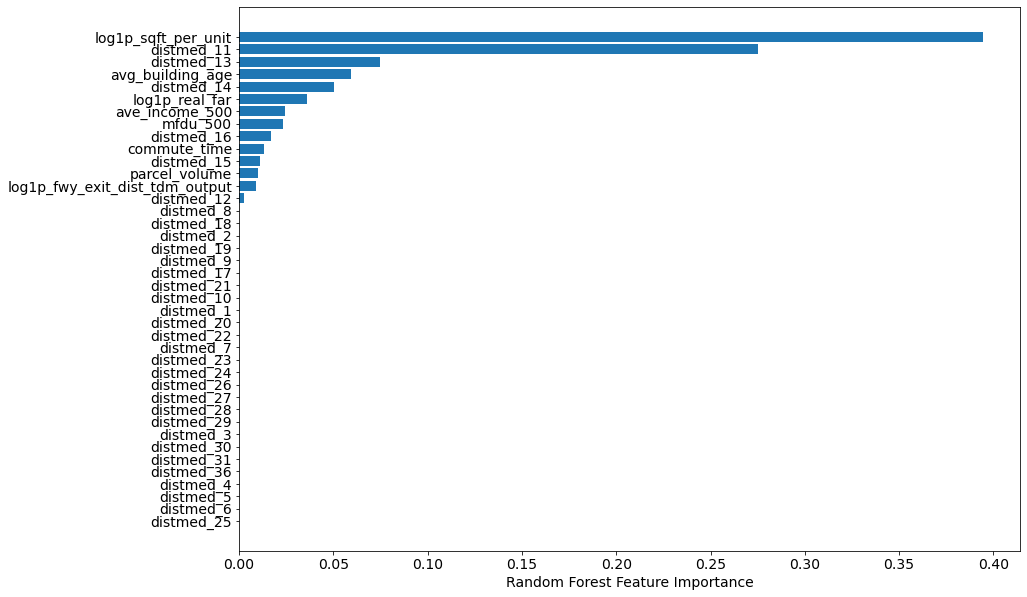

In [283]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Salt Lake

In [284]:
# arguments - check these
data = tbl_35
y_var = 'res_price_per_sqft'

old_vars =  ['ave_income_500',
             'commute_time',
             'distmed_1',
             'distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_13',
             'distmed_14',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_2',
             'distmed_20',
             'distmed_21',
             'distmed_22',
             'distmed_23',
             'distmed_24',
             'distmed_25',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_3',
             'distmed_30',
             'distmed_31',
             'distmed_36',
             'distmed_4',
             'distmed_5',
             'distmed_6',
             'distmed_7',
             'distmed_8',
             'distmed_9',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'mfdu_500',
             'log1p_sqft_per_unit', # np.log1p(sqft_per_unit)
             'log1p_real_far', # np.log1p(university_dist)
             'parcel_volume',
             'avg_building_age',  #I(avg_building_age < 21)[T.True]
            ]

In [285]:
# filters
mf = data[(data['building_type_id'] == 2) & (data['res_price_per_sqft'] > 0)].copy()

# get desired columns
mf = mf[old_vars + [y_var]].copy()

# separate independent and dependent variables
x_vars = mf[old_vars].copy()
y_var = mf[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:8314


In [286]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 2.506
Mean Squared Error: 58.203
R-squared scores: 0.904


Text(0.5, 0, 'Random Forest Feature Importance')

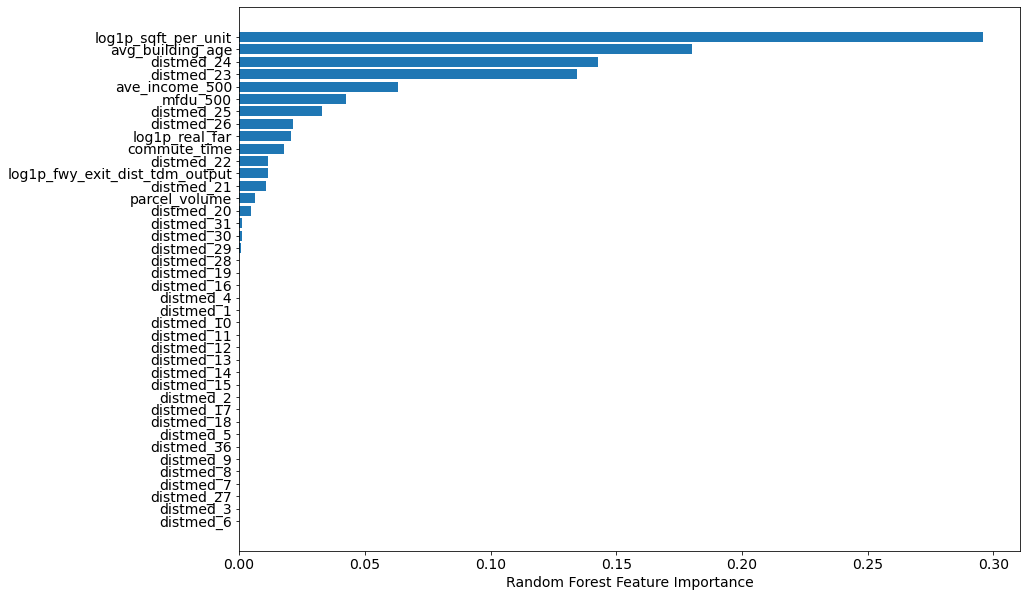

In [287]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Utah

In [288]:
# arguments - check these
data = tbl_49
y_var = 'res_price_per_sqft'

old_vars =  ['ave_income_500',
             'commute_time',
             'distmed_1',
             'distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_13',
             'distmed_14',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_2',
             'distmed_20',
             'distmed_21',
             'distmed_22',
             'distmed_23',
             'distmed_24',
             'distmed_25',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_3',
             'distmed_30',
             'distmed_31',
             'distmed_36',
             'distmed_4',
             'distmed_5',
             'distmed_6',
             'distmed_7',
             'distmed_8',
             'distmed_9',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'mfdu_500',
             'log1p_sqft_per_unit', # np.log1p(sqft_per_unit)
             'log1p_real_far', # np.log1p(university_dist)
             'parcel_volume',
             'avg_building_age',  #I(avg_building_age < 21)[T.True]
            ]

In [289]:
# filters
mf = data[(data['building_type_id'] == 2) & (data['res_price_per_sqft'] > 0)].copy()

# get desired columns
mf = mf[old_vars + [y_var]].copy()

# separate independent and dependent variables
x_vars = mf[old_vars].copy()
y_var = mf[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:8399


In [290]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 1.077
Mean Squared Error: 8.317
R-squared scores: 0.965


Text(0.5, 0, 'Random Forest Feature Importance')

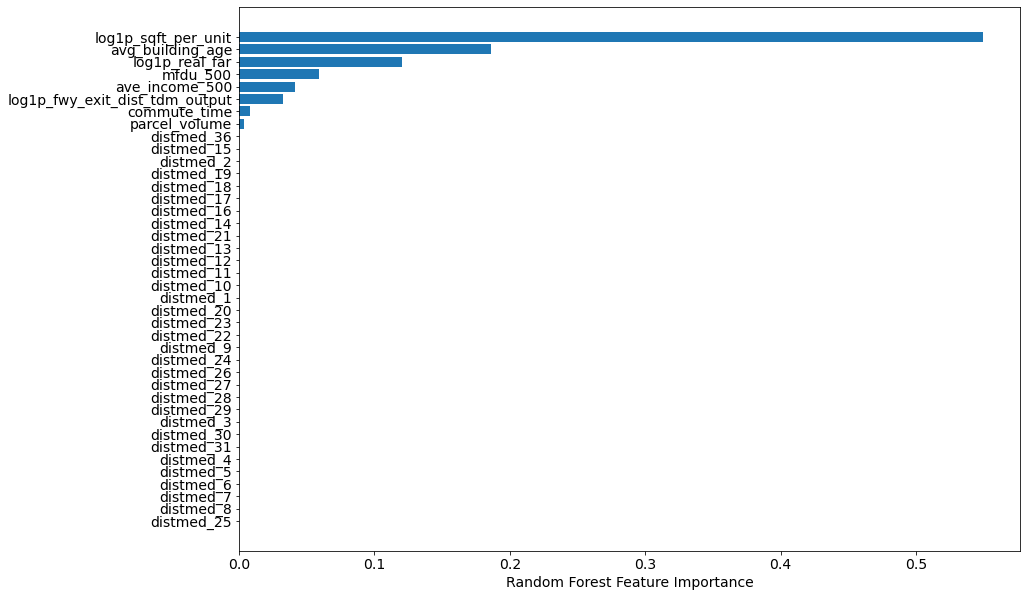

In [291]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

# Retail

###  Weber & Davis

In [292]:
# arguments - check these
data = pd.concat([comm_57, comm_11])
y_var = 'unit_price_non_residential'

old_vars =  ['distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_20',
             'distmed_21',
             'distmed_22',
             'distmed_25',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_30',
             'distmed_31',
             'distmed_32',
             'distmed_33',
             'distmed_34',
             'distmed_35',
             'distmed_36',
             'distmed_37',
             'distmed_38',
             'distmed_39',
             'distmed_4',
             'distmed_5',
             'distmed_6',
             'distmed_7',
             'distmed_9',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'jobs_1_500',
             'jobs_7_500',
             'train_stn_500',
             'log1p_real_far',
             'parcel_volume',
             'log1p_building_age',  #I(avg_building_age < 21)[T.True]
            ]

In [293]:
# filters
ret = data[(data['building_type_id_c'] == 4) & (data['unit_price_non_residential_c'] > 0)].copy()

# get desired columns
ret = ret[old_vars + [y_var]].copy()

# separate independent and dependent variables
x_vars = ret[old_vars].copy()
y_var = ret[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:156


In [294]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 14.777
Mean Squared Error: 847.052
R-squared scores: 0.742


Text(0.5, 0, 'Random Forest Feature Importance')

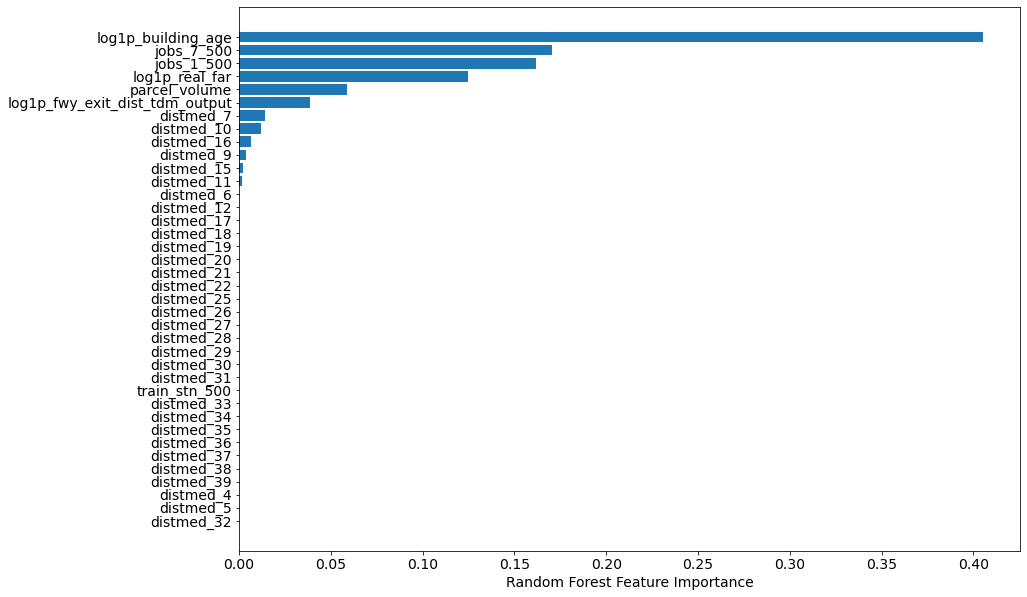

In [295]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Salt Lake

In [296]:
# arguments - check these
data = comm_35
y_var = 'unit_price_non_residential'

old_vars =  ['distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_20',
             'distmed_21',
             'distmed_22',
             'distmed_25',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_30',
             'distmed_31',
             'distmed_32',
             'distmed_33',
             'distmed_34',
             'distmed_35',
             'distmed_36',
             'distmed_37',
             'distmed_38',
             'distmed_39',
             'distmed_4',
             'distmed_5',
             'distmed_6',
             'distmed_7',
             'distmed_9',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'jobs_1_500',
             'jobs_7_500',
             'train_stn_500',
             'log1p_real_far',
             'parcel_volume',
             'log1p_building_age',  #I(avg_building_age < 21)[T.True]
            ]

In [297]:
# filters
ret = data[(data['building_type_id_c'] == 4) & (data['unit_price_non_residential_c'] > 0)].copy()

# get desired columns
ret = ret[old_vars + [y_var]].copy()

# separate independent and dependent variables
x_vars = ret[old_vars].copy()
y_var = ret[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:483


In [298]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 13.132
Mean Squared Error: 1068.077
R-squared scores: 0.673


Text(0.5, 0, 'Random Forest Feature Importance')

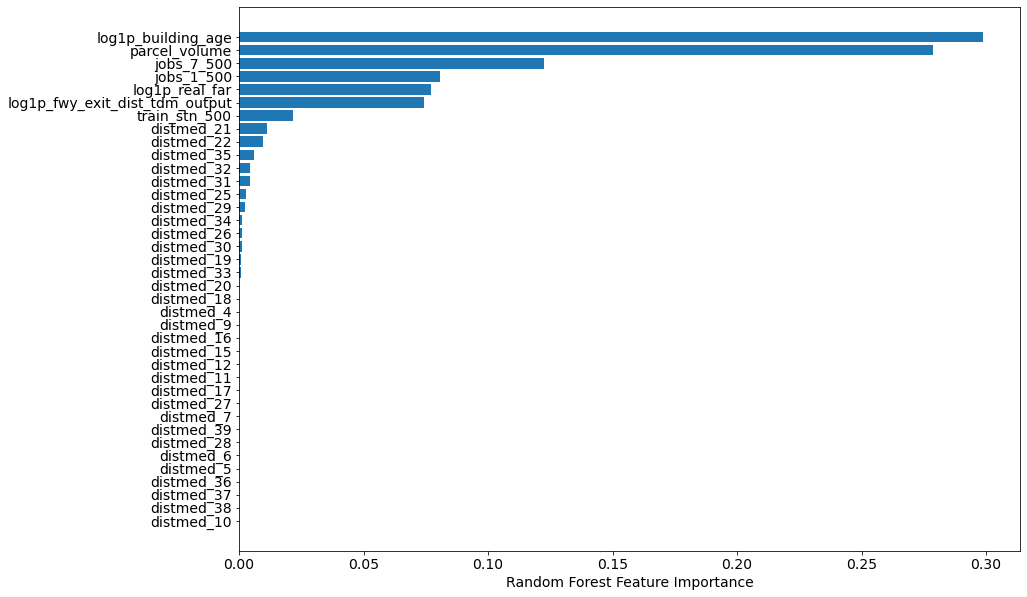

In [299]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Utah

In [300]:
# arguments - check these
data = comm_49
y_var = 'unit_price_non_residential'

old_vars =  ['distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_20',
             'distmed_21',
             'distmed_22',
             'distmed_25',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_30',
             'distmed_31',
             'distmed_32',
             'distmed_33',
             'distmed_34',
             'distmed_35',
             'distmed_36',
             'distmed_37',
             'distmed_38',
             'distmed_39',
             'distmed_4',
             'distmed_5',
             'distmed_6',
             'distmed_7',
             'distmed_9',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'jobs_1_500',
             'jobs_7_500',
             'train_stn_500',
             'log1p_real_far',
             'parcel_volume',
             'log1p_building_age',  #I(avg_building_age < 21)[T.True]
            ]

In [301]:
# filters
ret = data[(data['building_type_id_c'] == 4) & (data['unit_price_non_residential_c'] > 0)].copy()

# get desired columns
ret = ret[old_vars + [y_var]].copy()

# separate independent and dependent variables
x_vars = ret[old_vars].copy()
y_var = ret[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:204


In [302]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 12.921
Mean Squared Error: 1090.631
R-squared scores: 0.697


Text(0.5, 0, 'Random Forest Feature Importance')

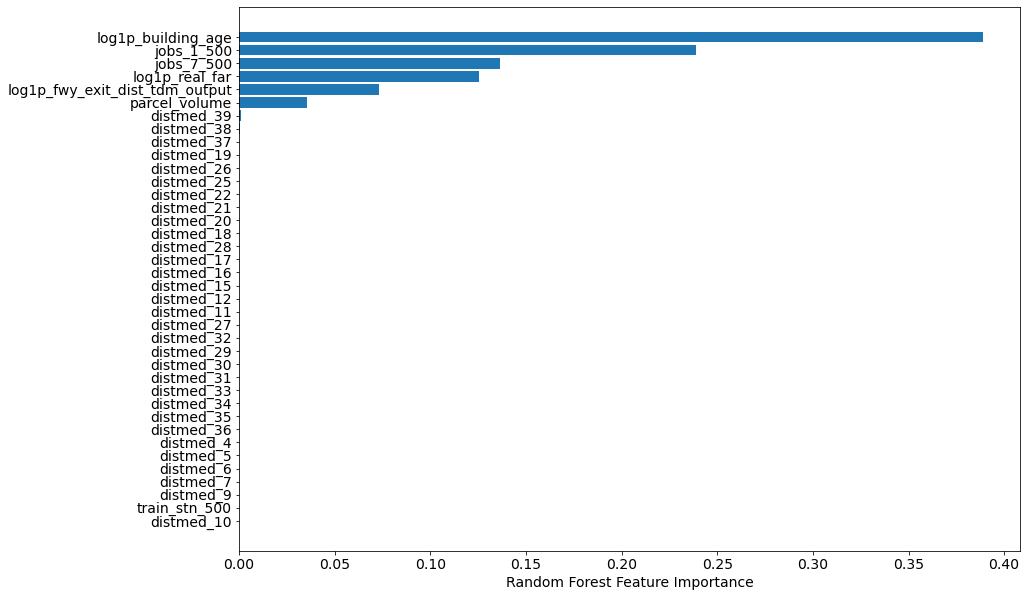

In [303]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

# Office

###  Weber & Davis

In [304]:
# arguments - check these
data = pd.concat([comm_57, comm_11])
y_var = 'unit_price_non_residential'

old_vars =  ['distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_13',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_20',
             'distmed_21',
             'distmed_22',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_30',
             'distmed_31',
             'distmed_32',
             'distmed_33',
             'distmed_34',
             'distmed_35',
             'distmed_36',
             'distmed_6',
             'distmed_8',
             'distmed_9',
             'land_value_per_acre',
             'logsum_hhinc4',
             'median_income',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'jobs_6_500',
             'log1p_real_far',
             'parcel_volume',
             'log1p_building_age',  #I(avg_building_age < 21)[T.True]
            ]

In [305]:
# filters
off = data[(data['building_type_id_c'] == 5) & (data['unit_price_non_residential_c'] > 0)].copy()

# get desired columns
off = off[old_vars + [y_var]].copy()

# separate independent and dependent variables
x_vars = off[old_vars].copy()
y_var = off[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:161


In [306]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 22.402
Mean Squared Error: 1460.555
R-squared scores: 0.772


Text(0.5, 0, 'Random Forest Feature Importance')

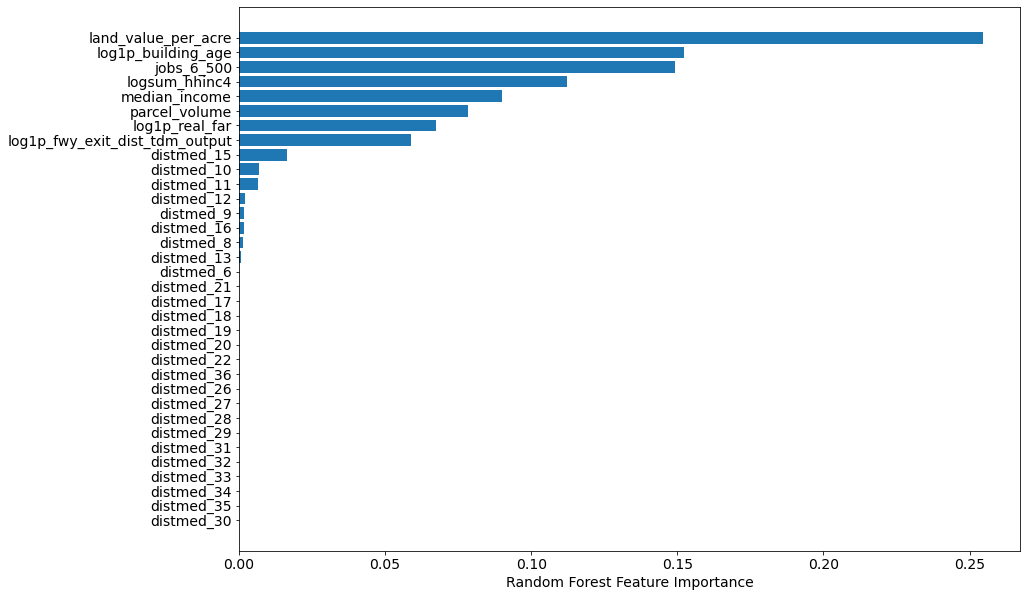

In [307]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Salt Lake

In [308]:
# arguments - check these
data = comm_35
y_var = 'unit_price_non_residential'

old_vars =  ['distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_13',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_20',
             'distmed_21',
             'distmed_22',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_30',
             'distmed_31',
             'distmed_32',
             'distmed_33',
             'distmed_34',
             'distmed_35',
             'distmed_36',
             'distmed_6',
             'distmed_8',
             'distmed_9',
             'land_value_per_acre',
             'logsum_hhinc4',
             'median_income',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'jobs_6_500',
             'log1p_real_far',
             'parcel_volume',
             'log1p_building_age',  #I(avg_building_age < 21)[T.True]
            ]

In [309]:
# filters
off = data[(data['building_type_id_c'] == 5) & (data['unit_price_non_residential_c'] > 0)].copy()

# get desired columns
off = off[old_vars + [y_var]].copy()

# separate independent and dependent variables
x_vars = off[old_vars].copy()
y_var = off[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:683


In [310]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 10.593
Mean Squared Error: 729.043
R-squared scores: 0.81


Text(0.5, 0, 'Random Forest Feature Importance')

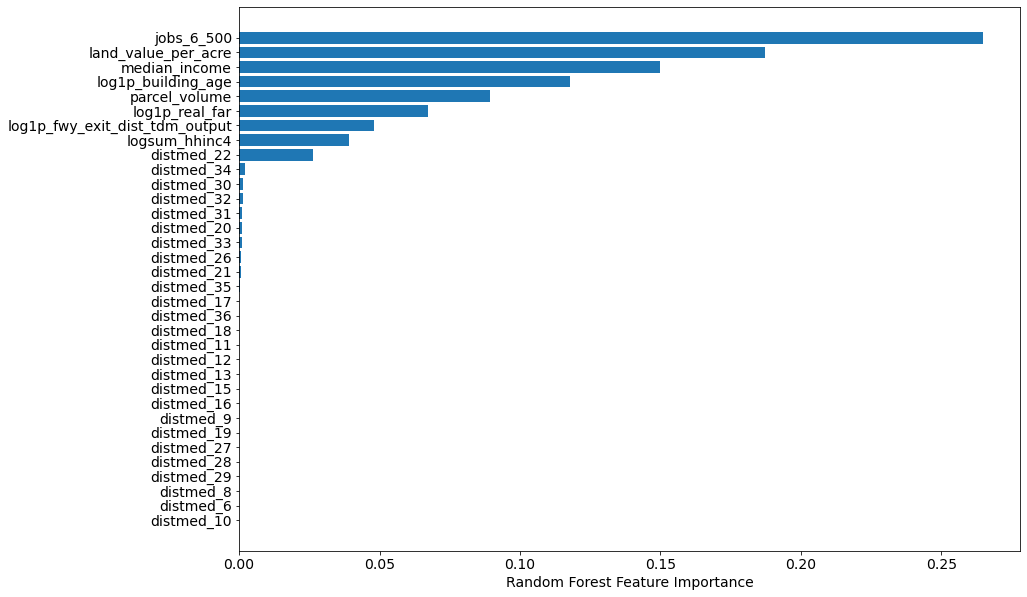

In [311]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Utah

In [312]:
# arguments - check these
data = comm_49
y_var = 'unit_price_non_residential'

old_vars =  ['distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_13',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_20',
             'distmed_21',
             'distmed_22',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_30',
             'distmed_31',
             'distmed_32',
             'distmed_33',
             'distmed_34',
             'distmed_35',
             'distmed_36',
             'distmed_6',
             'distmed_8',
             'distmed_9',
             'land_value_per_acre',
             'logsum_hhinc4',
             'median_income',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'jobs_6_500',
             'log1p_real_far',
             'parcel_volume',
             'log1p_building_age',  #I(avg_building_age < 21)[T.True]
            ]

In [313]:
# filters
off = data[(data['building_type_id_c'] == 5) & (data['unit_price_non_residential_c'] > 0)].copy()

# get desired columns
off = off[old_vars + [y_var]].copy()

# separate independent and dependent variables
x_vars = off[old_vars].copy()
y_var = off[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:212


In [314]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 14.587
Mean Squared Error: 1278.963
R-squared scores: 0.641


Text(0.5, 0, 'Random Forest Feature Importance')

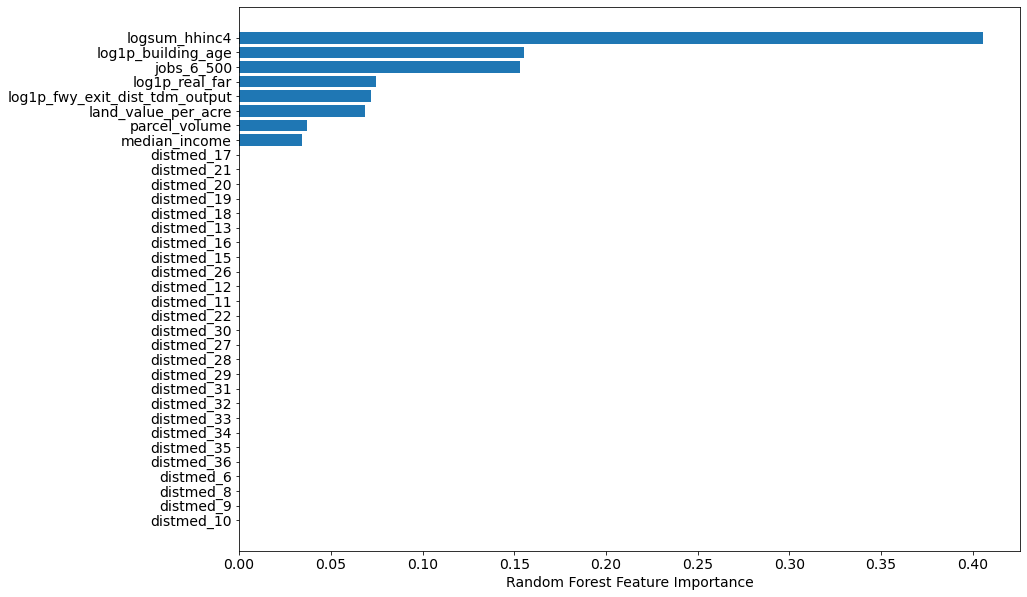

In [315]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

# Industrial

###  Weber & Davis

In [316]:
# arguments - check these
data = pd.concat([comm_57, comm_11])
y_var = 'unit_price_non_residential'

old_vars =  ['distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_13',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_20',
             'distmed_21',
             'distmed_25',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_30',
             'distmed_31',
             'distmed_32',
             'distmed_33',
             'distmed_34',
             'distmed_35',
             'distmed_36',
             'distmed_37',
             'distmed_4',
             'distmed_5',
             'distmed_6',
             'distmed_7',
             'distmed_9',
             'industrial_sqft_1000',
             'jobs_6_1000',
             'jobs_8_1000',
             'mfdu_1000',   #np.log1p(fwy_exit_dist_tdm_output)
             'rail_depot',
             'log1p_real_far', # np.log1p(university_dist)
             'parcel_volume',
             'log1p_building_age',  #I(avg_building_age < 21)[T.True]
            ]

In [317]:
# filters
ind = data[(data['building_type_id_c'] == 3) & (data['unit_price_non_residential_c'] > 0)].copy()

# get desired columns
ind = ind[old_vars + [y_var]].copy()

# separate independent and dependent variables
x_vars = ind[old_vars].copy()
y_var = ind[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:137


In [318]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 0.364
Mean Squared Error: 0.794
R-squared scores: 0.633


Text(0.5, 0, 'Random Forest Feature Importance')

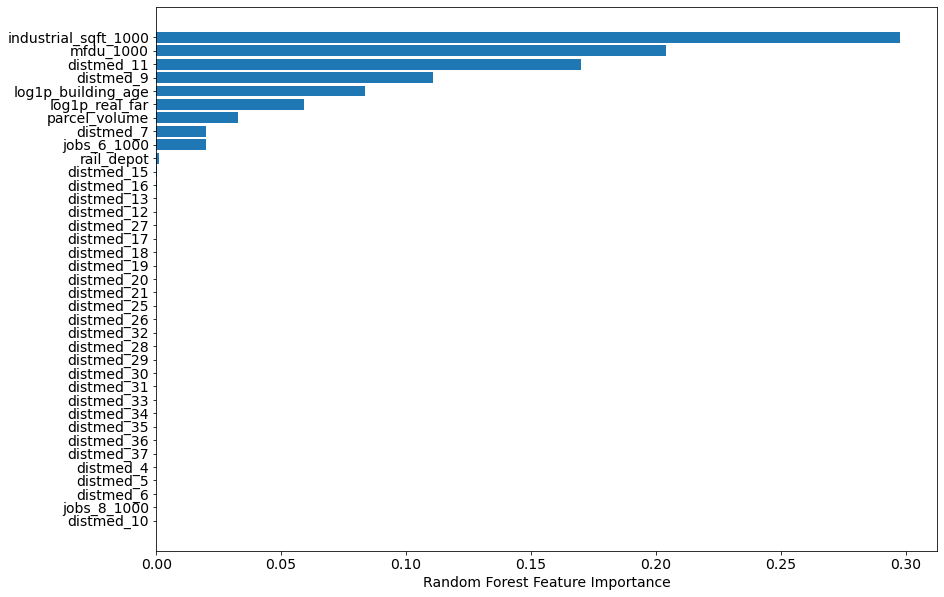

In [319]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Salt Lake

In [320]:
# arguments - check these
data = comm_35
y_var = 'unit_price_non_residential'

old_vars =  ['distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_13',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_20',
             'distmed_21',
             'distmed_25',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_30',
             'distmed_31',
             'distmed_32',
             'distmed_33',
             'distmed_34',
             'distmed_35',
             'distmed_36',
             'distmed_37',
             'distmed_4',
             'distmed_5',
             'distmed_6',
             'distmed_7',
             'distmed_9',
             'industrial_sqft_1000',
             'jobs_6_1000',
             'jobs_8_1000',
             'mfdu_1000',   #np.log1p(fwy_exit_dist_tdm_output)
             'rail_depot',
             'log1p_real_far', # np.log1p(university_dist)
             'parcel_volume',
             'log1p_building_age',  #I(avg_building_age < 21)[T.True]
            ]

In [321]:
# filters
ind = data[(data['building_type_id_c'] == 3) & (data['unit_price_non_residential_c'] > 0)].copy()

# get desired columns
ind = ind[old_vars + [y_var]].copy()

# separate independent and dependent variables
x_vars = ind[old_vars].copy()
y_var = ind[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:675


In [322]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 6.981
Mean Squared Error: 674.069
R-squared scores: 0.504


Text(0.5, 0, 'Random Forest Feature Importance')

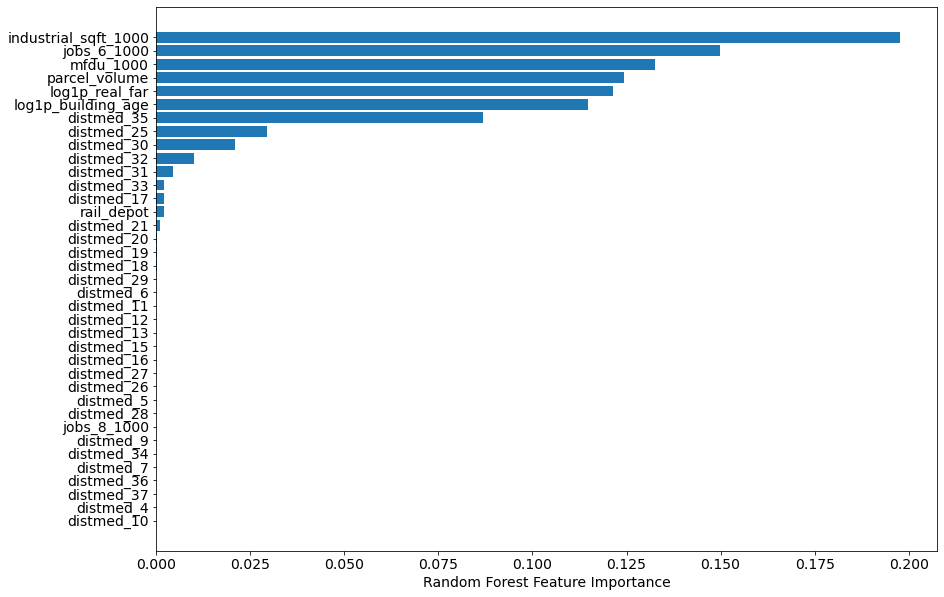

In [323]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Utah

In [324]:
# arguments - check these
data = comm_49
y_var = 'unit_price_non_residential'

old_vars =  ['distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_13',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_20',
             'distmed_21',
             'distmed_25',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_30',
             'distmed_31',
             'distmed_32',
             'distmed_33',
             'distmed_34',
             'distmed_35',
             'distmed_36',
             'distmed_37',
             'distmed_4',
             'distmed_5',
             'distmed_6',
             'distmed_7',
             'distmed_9',
             'industrial_sqft_1000',
             'jobs_6_1000',
             'jobs_8_1000',
             'mfdu_1000',   #np.log1p(fwy_exit_dist_tdm_output)
             'rail_depot',
             'log1p_real_far', # np.log1p(university_dist)
             'parcel_volume',
             'log1p_building_age',  #I(avg_building_age < 21)[T.True]
            ]

In [325]:
# filters
ind = data[(data['building_type_id_c'] == 5) & (data['unit_price_non_residential_c'] > 0)].copy()

# get desired columns
ind = ind[old_vars + [y_var]].copy()

# separate independent and dependent variables
x_vars = ind[old_vars].copy()
y_var = ind[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)
print("Training sample size:{}".format(int(x_train.shape[0])))

Training sample size:212


In [326]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 14.741
Mean Squared Error: 1346.332
R-squared scores: 0.622


Text(0.5, 0, 'Random Forest Feature Importance')

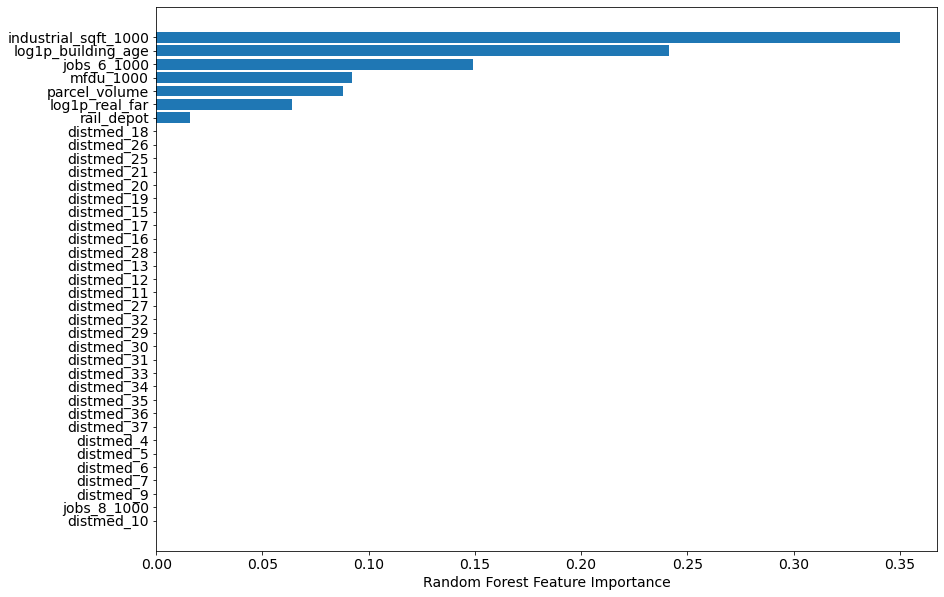

In [327]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")